# Machine Learning Workshop with NetApp FlexCache

本ワークショップは以下のTensorflow tutorialをもとに開発しております  
https://www.tensorflow.org/tutorials/keras/classification?hl=ja

このガイドでは、スニーカーやシャツなど、身に着けるものの画像を分類するニューラルネットワークのモデルをトレーニングします。すべての詳細を理解できなくても問題ありません。ここでは、完全な TensorFlow プログラムについて概説し、細かいところはその過程において見ていきます。

このガイドでは、TensorFlowのモデルを構築し訓練するためのハイレベルのAPIである [tf.keras](https://www.tensorflow.org/guide/keras)を使用します。

## ライブラリのインポート

In [1]:
import os
import numpy as np
import gzip

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.12.0


## Amazon FSx for NetApp ONTAP ボリュームのマウント確認

本Workshopでは機械学習に使用するデータセットはAmazon FSx for NetApp ONTAP上に格納しています  
以下にデモ環境の構成図を示します

現在のボリュームマウント状況を表示し、データセット用ボリューム、トレーニング済みモデルの格納用ボリュームがそれぞれノートブックインスタンスにマウントされていることを確認します

In [2]:
os.system("df -h")

Filesystem                             Size  Used Avail Use% Mounted on
devtmpfs                               1.9G     0  1.9G   0% /dev
tmpfs                                  1.9G     0  1.9G   0% /dev/shm
tmpfs                                  1.9G  620K  1.9G   1% /run
tmpfs                                  1.9G     0  1.9G   0% /sys/fs/cgroup
/dev/nvme0n1p1                         180G  135G   46G  75% /
/dev/nvme1n1                           4.8G  548K  4.6G   1% /home/ec2-user/SageMaker
tmpfs                                  386M     0  386M   0% /run/user/1002
tmpfs                                  386M     0  386M   0% /run/user/1001
tmpfs                                  386M     0  386M   0% /run/user/1000
10.104.4.166:/flexcache_onprem_to_aws  380G  3.8G  377G   1% /home/ec2-user/dataset
10.104.4.166:/non_cache_1               95G  9.2G   86G  10% /home/ec2-user/output


0

もしデータセット用ボリューム、トレーニング済みモデルの格納用ボリュームがマウントされていない場合には手動でマウントを行います

In [3]:
# マウント対象のjunction-path, マウントポイントなど（適宜書き換えてください）
NFS_SERVER = "10.104.4.166"
DATASET_DIR = "/flexcache_onprem_to_aws"
OUTPUT_DIR = "/non_cache_1"
DATASET_MOUNTPOINT="/home/ec2-user/dataset"
OUTPUT_MOUNTPOINT = "/home/ec2-user/output"

# OSコマンドの実行
os.system(f'mkdir -p {DATASET_MOUNTPOINT}')
os.system(f'mkdir -p {OUTPUT_MOUNTPOINT}')
os.system(f'sudo mount -t nfs {NFS_SERVER}:{DATASET_DIR} {DATASET_MOUNTPOINT}')
os.system(f'sudo mount -t nfs {NFS_SERVER}:{OUTPUT_DIR} {OUTPUT_MOUNTPOINT}')
os.system("df -h")

Filesystem                             Size  Used Avail Use% Mounted on
devtmpfs                               1.9G     0  1.9G   0% /dev
tmpfs                                  1.9G     0  1.9G   0% /dev/shm
tmpfs                                  1.9G  620K  1.9G   1% /run
tmpfs                                  1.9G     0  1.9G   0% /sys/fs/cgroup
/dev/nvme0n1p1                         180G  135G   46G  75% /
/dev/nvme1n1                           4.8G  548K  4.6G   1% /home/ec2-user/SageMaker
tmpfs                                  386M     0  386M   0% /run/user/1002
tmpfs                                  386M     0  386M   0% /run/user/1001
tmpfs                                  386M     0  386M   0% /run/user/1000
10.104.4.166:/flexcache_onprem_to_aws  380G  3.8G  377G   1% /home/ec2-user/dataset
10.104.4.166:/non_cache_1               95G  9.2G   86G  10% /home/ec2-user/output


mount.nfs: /home/ec2-user/dataset is busy or already mounted
mount.nfs: /home/ec2-user/output is busy or already mounted


0

## 補足：Fashion MNIST データセットについて

このガイドでは、[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) データセットを使用します。このデータセットには、10 カテゴリの 70,000 のグレースケール画像が含まれています。次のように、画像は低解像度（28 x 28 ピクセル）で個々の衣料品を示しています。

<table>
  <tr><td>     <img src="https://tensorflow.org/images/fashion-mnist-sprite.png" alt="Fashion MNIST sprite" width="600">   </td></tr>
  <tr><td align="center">     <b>図 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST サンプル</a> (作成者：Zalando、MIT ライセンス)<br> </td></tr>
</table>

Fashion MNISTは、画像処理のための機械学習での"Hello, World"としてしばしば登場する[MNIST](http://yann.lecun.com/exdb/mnist/) データセットの代替として開発されたものです。MNISTデータセットは手書きの数字（0, 1, 2 など）から構成されており、そのフォーマットはこれから使うFashion MNISTと全く同じです。

Fashion MNIST を使うのは、目先を変える意味もありますが、普通の MNIST よりも少しだけ手応えがあるからでもあります。どちらのデータセットも比較的小さく、アルゴリズムが期待したとおりに機能するかどうかを確認するために使われます。プログラムのテストやデバッグのためには、よい出発点になります。

ここでは、60,000 枚の画像を使用してネットワークをトレーニングし、10,000 枚の画像を使用して、ネットワークが画像の分類をどの程度正確に学習したかを評価します。Tensor Flow から直接 Fashion MNIST にアクセスできます。Tensor Flow から直接 [Fashion MNIST データをインポートして読み込みます](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data)。

## FlexCacheボリュームからのデータセットのロード

In [4]:
# データセットロード用関数の定義
# ref: https://github.com/zalandoresearch/fashion-mnist/issues/167
def load_data_fromlocalpath(input_path):
  """Loads the Fashion-MNIST dataset.
  Modified by Henry Huang in 2020/12/24.
  We assume that the input_path should in a correct path address format.
  We also assume that potential users put all the four files in the path.

  Load local data from path ‘input_path’.

  Returns:
      Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
  """
  files = [
      'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
      't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
  ]

  paths = []
  for fname in files:
    paths.append(os.path.join(input_path, fname))  # The location of the dataset.


  with gzip.open(paths[0], 'rb') as lbpath:
    y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[1], 'rb') as imgpath:
    x_train = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

  with gzip.open(paths[2], 'rb') as lbpath:
    y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[3], 'rb') as imgpath:
    x_test = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

  return (x_train, y_train), (x_test, y_test)

In [6]:
# あらかじめダウンロードしたデータセットの格納先パス
FASHION_MNIST_DATASET_DIR = f'{DATASET_MOUNTPOINT}/sagemaker/mnist_fashion_dataset/'

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = load_data_fromlocalpath(FASHION_MNIST_DATASET_DIR)

読み込んだデータセットは、NumPy 配列になります。

- `train_images` と `train_labels` の 2 つの配列は、モデルのトレーニングに使用される*トレーニング用データセット*です。
- モデルは、*テストセット*、`test_images`および`test_labels`  配列に対してテストされます。

画像は 28×28 の NumPy 配列から構成されています。それぞれのピクセルの値は 0 から 255 の間です。*ラベル*は、0 から 9 までの整数の配列です。それぞれの数字が下表のように、衣料品の*クラス*に対応しています。

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

画像はそれぞれ単一のラベルに分類されます。データセットには上記の**クラス名**が含まれていないため、後ほど画像を出力するときのために、クラス名を保存しておきます。

In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## データの前処理

ネットワークをトレーニングする前に、データを前処理する必要があります。最初の画像を調べてみればわかるように、ピクセルの値は 0 から 255 の間の数値です。

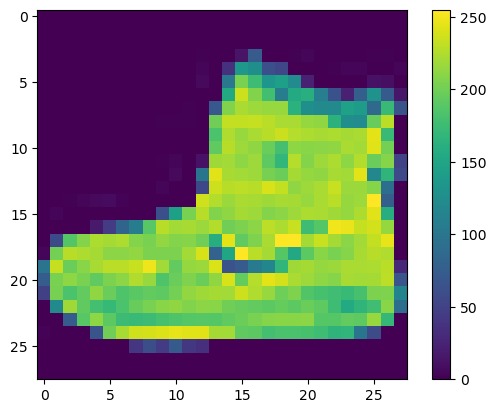

In [8]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

これらの値をニューラルネットワークモデルに供給する前に、0 から 1 の範囲にスケーリングします。これを行うには、値を 255 で割ります。*トレーニングセット*と*テストセット*を同じ方法で前処理することが重要です。

In [9]:
train_images = train_images / 255.0

test_images = test_images / 255.0

**訓練用データセット**の最初の25枚の画像を、クラス名付きで表示してみましょう。ネットワークを構築・訓練する前に、データが正しいフォーマットになっていることを確認します。

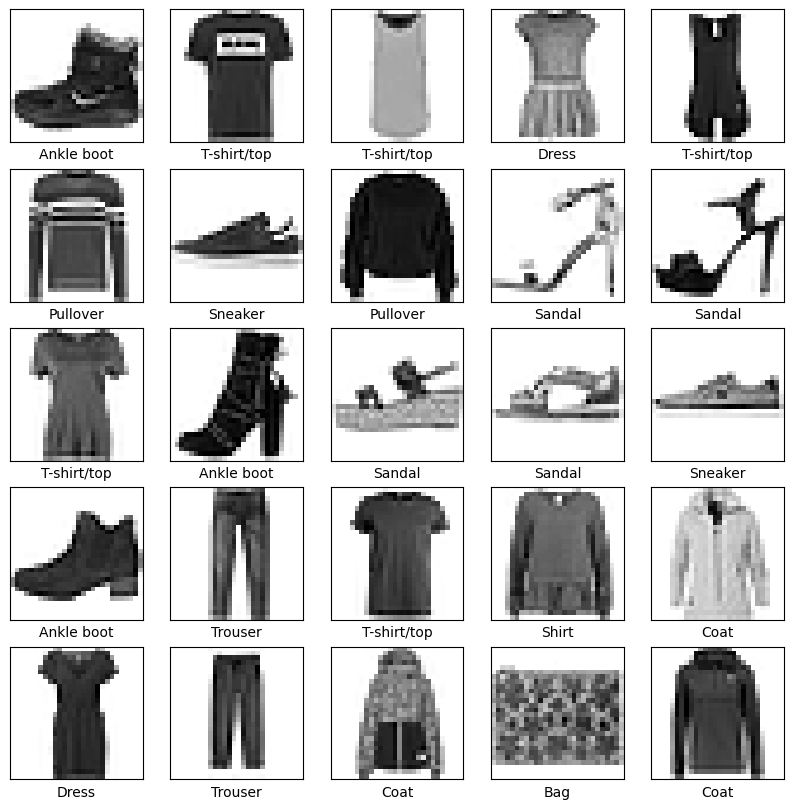

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## モデルの構築

ニューラルネットワークを構築するには、まずモデルのレイヤーを定義し、その後モデルをコンパイルします。

### レイヤーの設定

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

2023-08-01 09:33:23.562962: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### モデルのコンパイル

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## モデルの訓練

ニューラルネットワークモデルのトレーニングには、次の手順が必要です。

1. モデルトレーニング用データを投入します。この例では、トレーニングデータは `train_images` および <br>`train_labels` 配列にあります。
2. モデルは、画像とラベルの対応関係を学習します。
3. モデルにテスト用データセットの予測（分類）を行わせます。この例では `test_images` 配列です。その後、予測結果と `test_labels` 配列を照合します。
4. 予測が `test_labels` 配列のラベルと一致することを確認します。


### モデルに投入する

トレーニングを開始するには、[`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) メソッドを呼び出します。

In [13]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5002 - accuracy: 0.8238
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3769 - accuracy: 0.8652
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3362 - accuracy: 0.8780
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3122 - accuracy: 0.8851
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2924 - accuracy: 0.8917


モデルのトレーニングの進行とともに、損失値と正解率が表示されます。このモデルの場合、トレーニング用データでは 0.91 (すなわち 91%) の正解率に達します。

### 正解率を評価する

次に、モデルがテストデータセットでどのように機能するかを比較します。

In [14]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3596 - accuracy: 0.8712 - 925ms/epoch - 3ms/step

Test accuracy: 0.8712000250816345


### 予測する

トレーニングされたモデルを使用して、いくつかの画像に関する予測を行うことができます。ソフトマックスレイヤーをアタッチして、モデルの線形出力である[ロジット](https://developers.google.com/machine-learning/glossary#logits)を解釈しやすい確率に変換します。

In [15]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [16]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


これは、モデルがテスト用データセットの画像のひとつひとつを分類予測した結果です。最初の予測を見てみましょう。

In [17]:
predictions[0]

array([4.7704024e-08, 4.2612697e-08, 6.1351312e-07, 7.6025067e-08,
       3.2631544e-07, 4.7862390e-03, 5.5759319e-08, 9.6552325e-03,
       1.2947467e-05, 9.8554444e-01], dtype=float32)

予測結果は、10個の数字の配列です。これは、その画像が10の衣料品の種類のそれぞれに該当するかの「確信度」を表しています。どのラベルが一番確信度が高いかを見てみましょう。

In [18]:
np.argmax(predictions[0])

9

このモデルは、この画像が、アンクルブーツ、`class_names[9]`である可能性が最も高いと判断したことになります。これが正しいかどうか、テスト用ラベルを見てみましょう。

In [19]:
test_labels[0]

9

これをグラフ化して、10 クラスの予測の完全なセットを確認します。

In [20]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### 予測を検証する

トレーニングされたモデルを使用して、いくつかの画像に関する予測を行うことができます。

0 番目の画像、予測、および予測配列を見てみましょう。 正しい予測ラベルは青で、間違った予測ラベルは赤です。 数値は、予測されたラベルのパーセンテージ (/100) を示します。

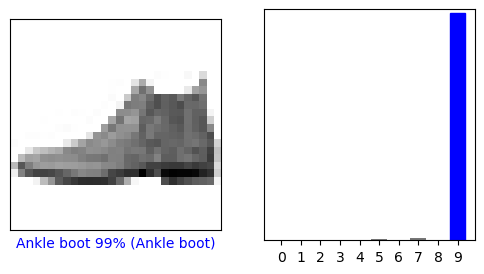

In [21]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

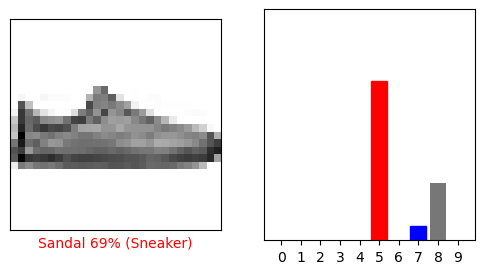

In [22]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

いくつかの画像をそれらの予測とともにプロットしてみましょう。確信度が高い場合でも、モデルが間違っていることがあることに注意してください。

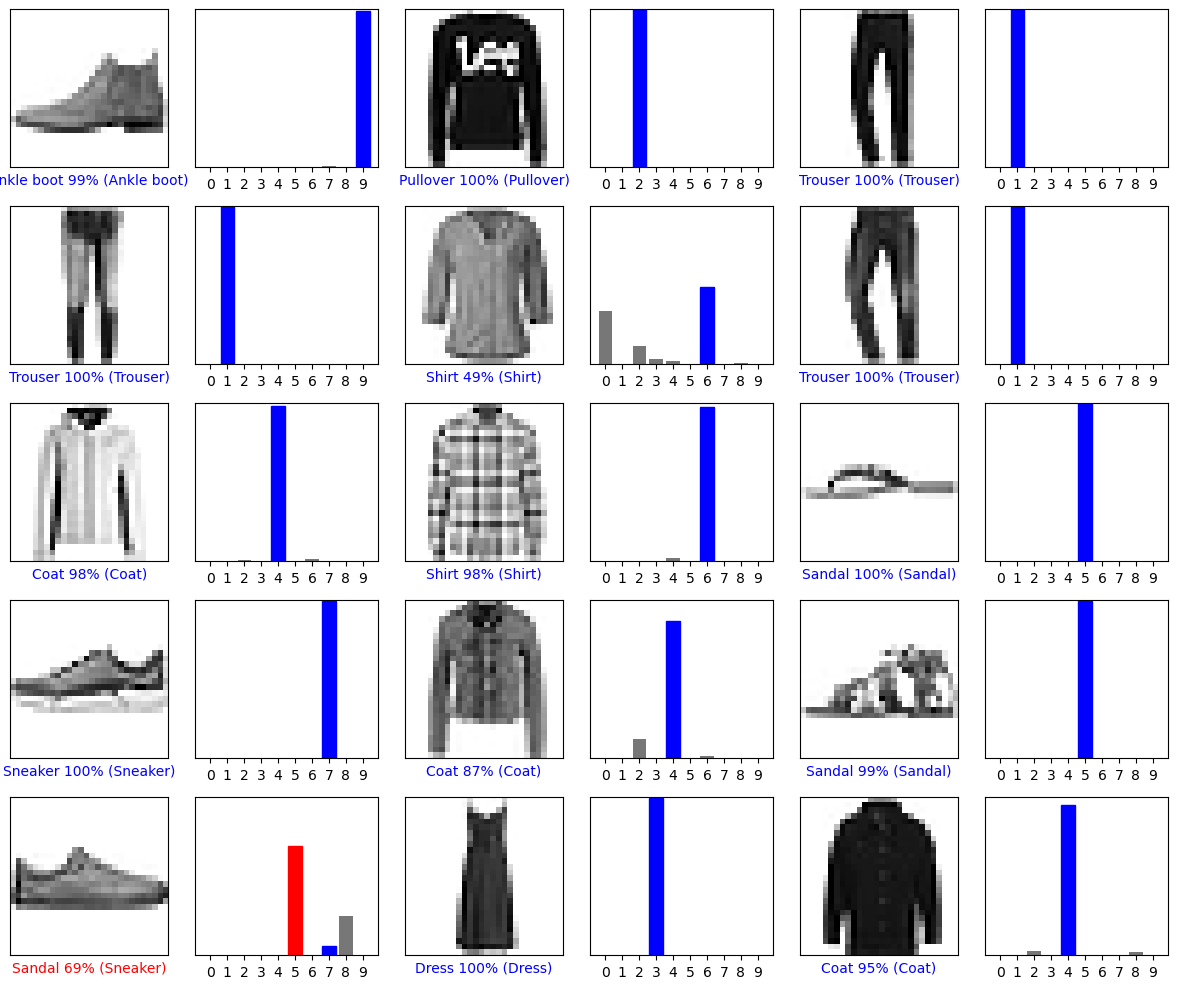

In [23]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## モデルの保存

トレーニング済みモデルをAmazon FSx for NetApp ONTAPのボリューム内に格納します

In [24]:
MODEL_OUTPUT_DIR = f'{OUTPUT_MOUNTPOINT}/sagemaker/mnist_fashion_classification/'
os.system(f'mkdir -p {MODEL_OUTPUT_DIR}')
model.save(MODEL_OUTPUT_DIR)

INFO:tensorflow:Assets written to: /home/ec2-user/output/sagemaker/mnist_fashion_classification/assets


INFO:tensorflow:Assets written to: /home/ec2-user/output/sagemaker/mnist_fashion_classification/assets


In [25]:
os.system(f'ls -l {MODEL_OUTPUT_DIR}')

total 108
drwxr-xr-x 2 ec2-user ec2-user  4096 Aug  1 09:26 assets
-rw-rw-r-- 1 ec2-user ec2-user    55 Aug  1 09:34 fingerprint.pb
-rw-rw-r-- 1 ec2-user ec2-user  7998 Aug  1 09:34 keras_metadata.pb
-rw-rw-r-- 1 ec2-user ec2-user 86220 Aug  1 09:34 saved_model.pb
drwxr-xr-x 2 ec2-user ec2-user  4096 Aug  1 09:34 variables


0